In [180]:
from pathlib import Path
import re
import pandas as pd
import numpy as np
import seaborn as sns
from omegaconf import OmegaConf

In [119]:
folders = [Path("/misc/lmbraid19/hoffmaja/clean/l1/cifar100/iid_iid/data/"),
           Path("/misc/lmbraid19/hoffmaja/clean/l1/cifar100/iid_aug/data/"),
           Path("/misc/lmbraid19/hoffmaja/clean/l1/cifar100/aug_aug/data/"), 
           Path("/misc/lmbraid19/hoffmaja/clean/weight/cifar100/iid_iid/data/"),
           Path("/misc/lmbraid19/hoffmaja/clean/weight/cifar100/iid_aug/data/"),
           Path("/misc/lmbraid19/hoffmaja/clean/weight/cifar100/aug_aug/data/")]

pretrained_folders = [Path("/misc/lmbraid19/hoffmaja/clean/baseline_train/cifar100/iid/data/baseline_train_iid000003/baseline_train_iid000003/"),
                      Path("/misc/lmbraid19/hoffmaja/clean/baseline_train/cifar100/aug/data/baseline_train_aug000003/baseline_train_aug000003/")]

In [62]:
orig_df = pd.read_csv(base_iid_path / "metrics.csv").iloc[-1: ]

In [63]:
orig_df["test_mCE"]

600    0.588656
Name: test_mCE, dtype: float64

In [132]:
def read_pretrained_csv(path, *paths):
    if len(paths):
        return pd.concat([read_pretrained_csv(p) for p in [path, *paths]], sort=False)

    path = Path(path)

    df = pd.read_csv(path / "metrics.csv").iloc[-1: ]  # Only test

    cfg = OmegaConf.load(path / "configs.yaml")
    df["clean Error"] = 1 - df["test_acc_clean"]
    df["Loss Function"] = cfg.loss["_target_"].split(".")[-1]

    return df


def read_prune_csv(path, *paths):
    if len(paths):
        return pd.concat([read_prune_csv(p) for p in [path, *paths]], sort=False)

    path = Path(path)

    df = pd.read_csv(path / "metrics.csv").iloc[-1: ]  # Only test

    cfg = OmegaConf.load(path / "configs.yaml")
    df["clean Error"] = 1 - df["test_acc_clean"]
    df["method"] = cfg.prune.method
    df["ratio"] = cfg.prune.ratio
    df["Loss Function"] = cfg.loss["_target_"].split(".")[-1]
    df["pretrained"] = cfg.path.model.split("/")[-2]

    return df

In [134]:
paths = [p for f in folders for p in f.glob("*/*_*_*/")]
df = read_prune_csv(*paths)
df = df.sort_values(by=["method", "Loss Function", "ratio"])

In [135]:
df_orig = read_pretrained_csv(*pretrained_folders)

In [188]:
df_orig["test_mCE"]

600    0.588656
600    0.460255
Name: test_mCE, dtype: float64

In [185]:
loss_map = {"standard": "StandardLoss",
            "augmix": "AugmixLoss"}

for name in loss_map:
    loss_func = loss_map[name]
    df_orig_part = df_orig[df_orig["Loss Function"] == loss_func]
    df.loc[df.pretrained==name, "orig clean Error"] = df_orig_part["clean Error"].item()
    df.loc[df.pretrained==name, "orig test_mCE"] = df_orig_part["test_mCE"].item()

df["delta mCE"] = df["test_mCE"] - df["orig test_mCE"]
df["delta clean Error"] = df["clean Error"] - df["orig clean Error"]
df["delta distr"] = df["test_mCE"] - df["clean Error"] # - (df["orig test_mCE"] - df["orig clean Error"])
df["pretrained, loss"] = df["pretrained"] + ", " + df["Loss Function"]

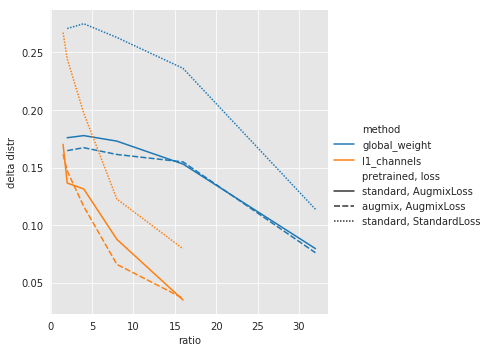

In [186]:
sns.set_style("darkgrid", {"axes.facecolor": ".9"})
g = sns.relplot(data=df, x="ratio", y="delta distr", hue="method", style="pretrained, loss", kind="line")

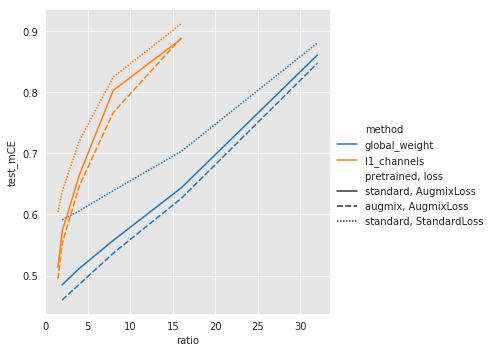

In [176]:
sns.set_style("darkgrid", {"axes.facecolor": ".9"})
g = sns.relplot(data=df, x="ratio", y="test_mCE", hue="method", style="pretrained, loss", kind="line")

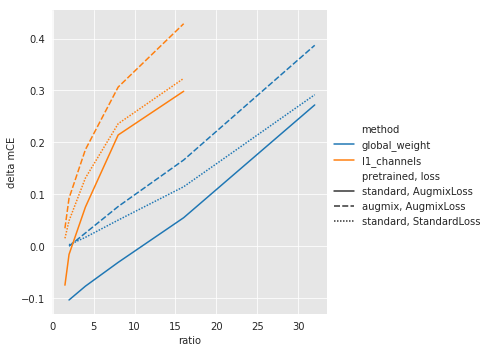

In [173]:
sns.set_style("darkgrid", {"axes.facecolor": ".9"})
g = sns.relplot(data=df, x="ratio", y="delta mCE", hue="method", style="pretrained, loss", kind="line")

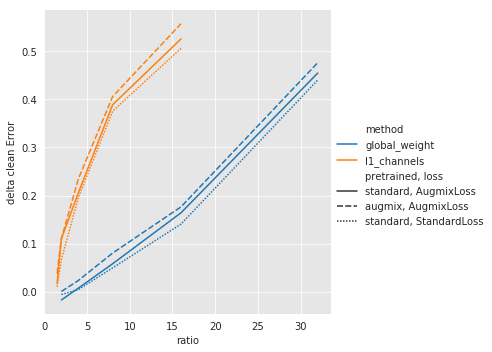

In [174]:
sns.set_style("darkgrid", {"axes.facecolor": ".9"})
g = sns.relplot(data=df, x="ratio", y="delta clean Error", hue="method", style="pretrained, loss", kind="line")

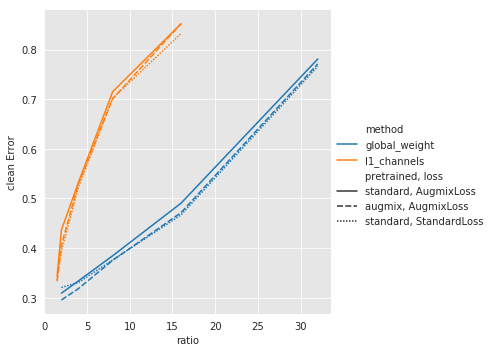

In [177]:
sns.set_style("darkgrid", {"axes.facecolor": ".9"})
g = sns.relplot(data=df, x="ratio", y="clean Error", hue="method", style="pretrained, loss", kind="line")

In [64]:
df["test_mCE"] - orig_df["test_mCE"].item()

150    0.002676
150    0.017076
150    0.050234
150    0.114503
150    0.291728
150    0.015168
150    0.049055
150    0.131310
150    0.235917
150    0.323201
Name: test_mCE, dtype: float64

In [65]:
- df["test_acc_clean"] + orig_df["test_acc_clean"].item()

150   -0.0058
150    0.0044
150    0.0495
150    0.1406
150    0.4402
150    0.0102
150    0.0669
150    0.1963
150    0.3755
150    0.5060
Name: test_acc_clean, dtype: float64

In [11]:
list(iid_iid_path.glob("*/*_*_*/"))

[PosixPath('/misc/lmbraid19/hoffmaja/clean/l1/cifar100/iid_iid/data/l1_iid_iid000005/l1_iid_iid000005'),
 PosixPath('/misc/lmbraid19/hoffmaja/clean/l1/cifar100/iid_iid/data/l1_iid_iid000002/l1_iid_iid000002'),
 PosixPath('/misc/lmbraid19/hoffmaja/clean/l1/cifar100/iid_iid/data/l1_iid_iid000003/l1_iid_iid000003'),
 PosixPath('/misc/lmbraid19/hoffmaja/clean/l1/cifar100/iid_iid/data/l1_iid_iid000004/l1_iid_iid000004'),
 PosixPath('/misc/lmbraid19/hoffmaja/clean/l1/cifar100/iid_iid/data/l1_iid_iid000001/l1_iid_iid000001')]

In [ ]:
def read_params(path):
    cfg = OmegaConf.load(path/"configs.yaml")
    return cfg.prune.ratio, cfg.prune.method

def read_csv(path, *paths):
    if len(paths):
        return pd.concat([read_csv(p) for p in paths], sort=False)
    
    path = Path(path)
    
    match = regex.match(path.name)
    df = pd.read_csv(path / "metric.csv").iloc[-1: ]  # Only test
    df["method"] = match.group("method")Dokument per Post zu. 
    df["ratio"] = float(match.group("ratio"))
    df["loss"] = match.group("loss")

    return df

def build_df(path, with_params=True):
    df = pd.read_csv(path/"metrics.csv").iloc[-1]
    df = df.filter(regex="test_acc_*")
    if with_params:
        ratio, method = read_params(path)

        df["ratio"] = ratio
        df["method"] = method
    return df.to_frame().T

def build_all(with_params=True, **groups):
    dfs = []
    for name, paths in groups.items():
        for path in paths:
            df = build_df(path, with_params)
            df["group"] = name
            dfs.append(df)
    df = pd.concat(dfs, sort=True)
    df["clean_error"] = 1 - pd.to_numeric(df["test_acc_clean"])
    df["mCE"] = 1 - df.filter(regex="test_acc_*").mean(axis=1)
    return df

df = build_all(augmix=augmix_paths, standard=standard_paths)